<a href="https://colab.research.google.com/github/DangTran-hub/Traffic_Signs/blob/main/Traffic_Sign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#Step 1. Mount drive
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/traffic_signs/dataset"
train_path = f"{dataset_path}/train"
test_path  = f"{dataset_path}/test"
val_path   = f"{dataset_path}/val"
#

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!pip install tensorflow
!pip install matplotlib
!pip install gradio


In [15]:
# Số lượng ảnh trước khi augmentation
import os

CLASS_NAMES = ['no_turn_left','force_to_right']

def count_images_in_splits(base_paths, class_names):
    total_counts = {c: 0 for c in class_names}
    for base_path in base_paths:
        if not os.path.exists(base_path):
            print(f"Warning: Directory not found: {base_path}")
            continue
        for c in class_names:
            class_dir = os.path.join(base_path, c)
            if os.path.isdir(class_dir):
                total_counts[c] += len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
    return total_counts
paths_to_check = [train_path, test_path, val_path]

raw_counts = count_images_in_splits(paths_to_check, CLASS_NAMES)
print("Số ảnh mỗi lớp trước augmentation:", raw_counts)


Số ảnh mỗi lớp trước augmentation: {'no_turn_left': 134, 'force_to_right': 63}


In [11]:
# Tiền xử lý ảnh
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.7,1.3],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/traffic_signs/dataset/train',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/traffic_signs/dataset/val',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/traffic_signs/dataset/test',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)


Found 141 images belonging to 2 classes.
Found 39 images belonging to 2 classes.
Found 17 images belonging to 2 classes.


In [12]:
# Xây dựng mô hình CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 lớp
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Huấn luyện mô hinhf
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.5997 - loss: 2.9479 - val_accuracy: 0.4872 - val_loss: 0.7152
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - accuracy: 0.8110 - loss: 0.4502 - val_accuracy: 0.4872 - val_loss: 0.6102
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 725ms/step - accuracy: 0.7800 - loss: 0.3169 - val_accuracy: 0.4872 - val_loss: 0.5300
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step - accuracy: 0.7883 - loss: 0.2574 - val_accuracy: 0.4872 - val_loss: 0.5204
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.7774 - loss: 0.2550 - val_accuracy: 0.4872 - val_loss: 0.4938
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step - accuracy: 0.8917 - loss: 0.1659 - val_accuracy: 0.8462 - val_loss: 0.3773
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - accuracy: 0.9610 - loss: 0.1666 - val_accuracy: 0.8462 - val_loss: 0.3725
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 621ms/step - accuracy: 0.9534 - loss: 0.1415 - val_accuracy: 0.5385 - val_loss: 0

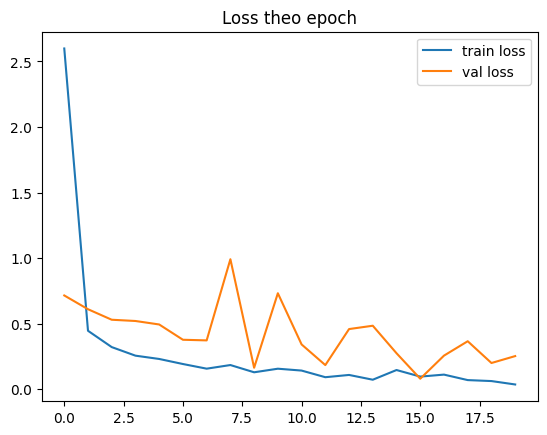

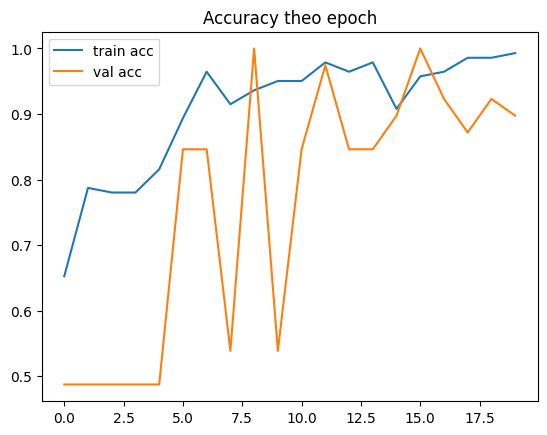

In [19]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss theo epoch')
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy theo epoch')
plt.show()


In [20]:
import gradio as gr
import numpy as np
from PIL import Image

def predict_image(img):
    img = img.resize((128,128))
    img_array = np.array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    classes = ['Cấm rẽ trái', 'Bắt buộc rẽ phải']
    return {classes[i]: float(prediction[0][i]) for i in range(2)}

iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2)
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1a2c372f4df3ed810b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


KeyboardInterrupt: 